In [1]:
import pandas as pd
import numpy as np

In [2]:
hin_df_folder = "/kaggle/input/modified-hate-speech-bengali-hindi/hindi-hate-speech/"
hin_df_dict = {}
hin_df_dict['train'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_train.csv")
hin_df_dict['test'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_test.csv")
hin_df_dict['valid'] = pd.read_csv(hin_df_folder + "hindi-hate-speech_valid.csv")

In [3]:
from datasets import Dataset, DatasetDict

In [4]:
hin_dataset_dict = DatasetDict()
for key in hin_df_dict.keys():
    hin_dataset_dict[key] = Dataset.from_pandas(hin_df_dict[key])

In [5]:
features = hin_dataset_dict['train'].column_names
features.remove('text')
num_features = len(features)
features, num_features

(['defamation', 'hate', 'non-hate', 'violence', 'vulgar'], 5)

In [6]:
id2label = {}
label2id = {}
for i, feature in enumerate(features):
    id2label[str(i)] = feature
    label2id[feature] = i

In [7]:
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification

2024-05-04 18:25:32.076366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 18:25:32.076457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 18:25:32.212931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
model_name = "l3cube-pune/hindi-bert-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=num_features,
    id2label=id2label,
    label2id=label2id
)

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hindi-bert-v2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize_dataset(dataset):
    encoding = tokenizer(
        dataset['text'],
        padding="max_length",
        max_length=256,
        truncation=True
    )
    labels_batch = {k: dataset[k] for k in dataset.keys() if k in features}
    labels_matrix = np.zeros((len(dataset['text'],), len(features)))
    for idx, label in enumerate(features):
        labels_matrix[:, idx] = labels_batch[label]
    encoding['labels'] = labels_matrix.tolist()
    return encoding

encoded_dataset_dict_tokenized = hin_dataset_dict.map(
    tokenize_dataset,
    batched=True,
    remove_columns=['text'] + features
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/5728 [00:00<?, ? examples/s]

Map:   0%|          | 0/1653 [00:00<?, ? examples/s]

Map:   0%|          | 0/811 [00:00<?, ? examples/s]

In [10]:
encoded_dataset_dict_tokenized.set_format(
    type='torch'
)

In [11]:
encoded_dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5728
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1653
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 811
    })
})

In [12]:
import sklearn.metrics as matrices
from transformers import EvalPrediction

In [13]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    probs = tf.math.sigmoid(predictions)
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = matrices.f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = matrices.roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = matrices.accuracy_score(y_true, y_pred)
    hamming_loss = matrices.hamming_loss(y_true, y_pred)
    jaccard_score = matrices.jaccard_score(y_true, y_pred, average='micro')
    zero_one_loss = matrices.zero_one_loss(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'hamming_loss': hamming_loss,
        'jaccard_score': jaccard_score,
        'zero_one_loss': zero_one_loss
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [14]:
from transformers import TrainingArguments, Trainer

In [54]:
args = TrainingArguments(
    output_dir='./results/',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [55]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_dict_tokenized['train'],
    eval_dataset=encoded_dataset_dict_tokenized['valid'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [56]:
import os

In [57]:
files = os.listdir(args.output_dir)
if len(files) == 0:
    trainer.train()
else:
    trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Hamming Loss,Jaccard Score,Zero One Loss,Runtime,Samples Per Second,Steps Per Second
16,0.255400,0.248369,0.740439,0.806436,0.689273,0.078668,0.587855,0.310727,6.627200,122.374000,3.923000
17,0.234400,0.241875,0.735818,0.804845,0.688039,0.080395,0.582051,0.311961,6.649700,121.960000,3.910000
18,0.234400,0.237510,0.733061,0.801998,0.685573,0.080641,0.578608,0.314427,6.647800,121.995000,3.911000
19,0.234400,0.234972,0.738956,0.808232,0.686806,0.080148,0.585987,0.313194,6.640300,122.132000,3.915000
20,0.219800,0.233849,0.736415,0.804995,0.688039,0.080148,0.582798,0.311961,6.653300,121.894000,3.908000


In [58]:
trainer.evaluate()

{'eval_loss': 0.24836939573287964,
 'eval_f1': 0.7404393816110659,
 'eval_roc_auc': 0.8064357460909185,
 'eval_accuracy': 0.689272503082614,
 'eval_hamming_loss': 0.07866831072749692,
 'eval_jaccard_score': 0.5878552971576227,
 'eval_zero_one_loss': 0.310727496917386,
 'eval_runtime': 6.5924,
 'eval_samples_per_second': 123.021,
 'eval_steps_per_second': 3.944,
 'epoch': 20.0}

In [59]:
actual_labels = encoded_dataset_dict_tokenized['test']['labels']
pred_labels = trainer.predict(
    encoded_dataset_dict_tokenized['test']
)

In [60]:
probs = tf.math.sigmoid(pred_labels.predictions)
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.3)] = 1

In [61]:
print('Accuracy Score: ', matrices.accuracy_score(actual_labels, y_pred))
print('F1 Score: ', matrices.f1_score(actual_labels, y_pred, average='micro'))
print('ROC AUC: ', matrices.roc_auc_score(actual_labels, y_pred, average='micro'))
print('Hamming Loss: ', matrices.hamming_loss(actual_labels, y_pred))
print('Jaccard Score: ', matrices.jaccard_score(actual_labels, y_pred, average='micro'))
print('Zero-One Loss:', matrices.zero_one_loss(actual_labels, y_pred))

print('\nClassification Report :-\n',
      matrices.classification_report(
          actual_labels,
          y_pred,
          output_dict=False,
          target_names=features,
      )
     )

Accuracy Score:  0.5553539019963702
F1 Score:  0.6801183750336292
ROC AUC:  0.8519891514304204
Hamming Loss:  0.14385964912280702
Jaccard Score:  0.5152874031797798
Zero-One Loss: 0.44464609800362975

Classification Report :-
               precision    recall  f1-score   support

  defamation       0.27      0.43      0.33       169
        hate       0.47      0.73      0.57       234
    non-hate       0.72      0.99      0.83       873
    violence       0.00      0.00      0.00         0
      vulgar       0.51      0.70      0.59       219

   micro avg       0.57      0.85      0.68      1495
   macro avg       0.39      0.57      0.46      1495
weighted avg       0.60      0.85      0.70      1495
 samples avg       0.61      0.71      0.64      1495



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
import matplotlib.pyplot as plt

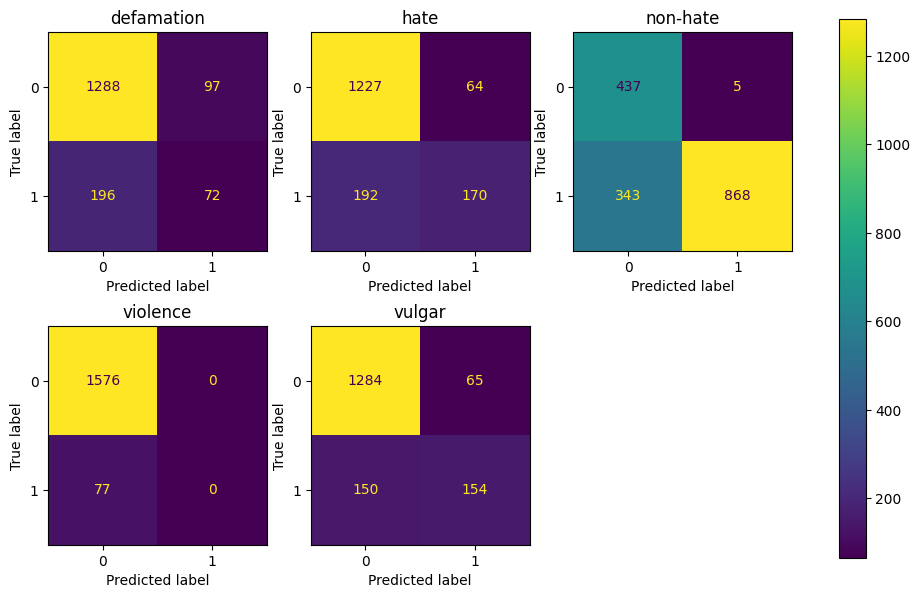

In [63]:
confusion_matrices =  matrices.multilabel_confusion_matrix(
    y_pred,
    actual_labels
)

fig, axis = plt.subplots(2, 3, figsize=(12, 7))
axis = axis.ravel()
for i in range(len(confusion_matrices)):
    disp = matrices.ConfusionMatrixDisplay(
        confusion_matrices[i],
    )
    disp.plot(ax=axis[i], values_format='.4g')
    disp.ax_.set_title(features[i])
    disp.im_.colorbar.remove()
fig.colorbar(disp.im_, ax=axis)
axis[5].remove()

In [64]:
trained_model_name = model_name.split('/')[1] + '-hate-speech-ben-hin-epochs-' + str(args.num_train_epochs)
trainer.save_model('./' + trained_model_name)

In [65]:
os.system("cd /kaggle/working/; zip -r "+trained_model_name+".zip ./"+trained_model_name)

  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/ (stored 0%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/special_tokens_map.json (deflated 80%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/training_args.bin (deflated 51%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/vocab.txt (deflated 61%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/tokenizer_config.json (deflated 75%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/config.json (deflated 52%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/tokenizer.json (deflated 70%)
  adding: hindi-bert-v2-hate-speech-ben-hin-epochs-20/model.safetensors (deflated 7%)


0

In [27]:
os.system("rm -r ./" + trained_model_name)

0